TOPICOS QUE PODEM SER INTERESSANTES:
- Ver como se comportam as networks com palavras com mais que um significado.
- Existem networks, por exemplo, de cenas relacionadas com racismo? Se sim, pode ser usado para detenção. (MOTIFS)
- Falar de que temos um set de bues palavras mas um texto nao usa tantas palavras, procurar quantas palavras diferentes costuma ter um texto e criar uma random network com isso.

In [76]:
import matplotlib.pyplot as plt
import networkx as nx
from src.random_text import get_text
# %pip install faker
from textblob import TextBlob
import random
import numpy as np


From Text to Word-adjacency networks

In [3]:
def get_network(text, disconnected_chars = ['.', ','], weighted=False):
    network = nx.DiGraph()
    words = text.split(" ")
    network.add_node(words[0])
    for (n, word) in enumerate(words[1:]):
        n+=1
        network.add_node(word)
        edge = (words[n-1], words[n])
        if edge in network.edges() and weighted:
            network.add_edge(edge[0], edge[1], weight=network.get_edge_data(*edge)['weight']+1)
        elif weighted: network.add_edge(*edge, weight=1)
        else: network.add_edge(*edge)
    
    network.remove_nodes_from(disconnected_chars)
    return network

Obtain text to analyse

In [58]:
text = get_text(size=10)

Convert from Text-To-Network

In [5]:
network = get_network(text, weighted=False)
print(network.edges())

[('footballer', 'abelmoschus'), ('abelmoschus', 'implunge'), ('implunge', 'unretired'), ('unretired', 'tendrilous'), ('tendrilous', 'xenogamous'), ('xenogamous', 'pessimal'), ('pessimal', 'throttle'), ('throttle', 'difficultness'), ('difficultness', 'conventionize')]


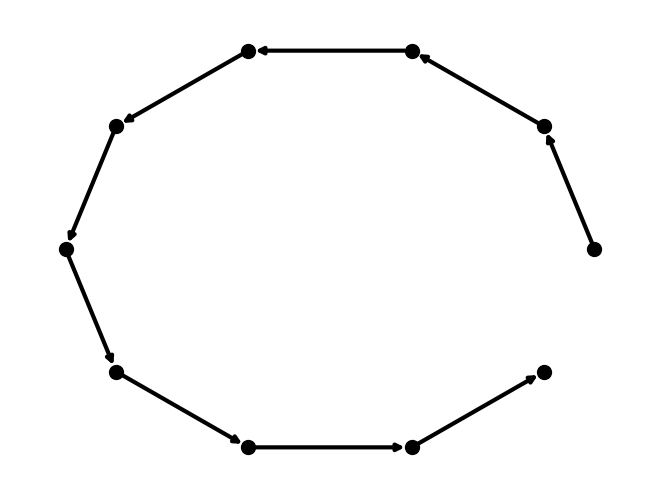

In [6]:
G = network
options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}
nx.draw_circular(G, **options)
nw = plt.show()

Network Properties:

(1) Degree Distribuition: 


É importante definir 3 situações: Um node só tem degree 1 se for um node no inicio ou no final de TODO o texto + não se repetindo. Um node tem degree 2 se for uma palavra que só se repete uma única vez no texto. Sempre que uma palavra se repete, terá sempre degree ímpar, considerando que se a palavra após for uma palavra que também estava após da mesma palavra numa recorrência anterior é considerada um novo edge.


Probabilidade de haver um node com degree n > 2, num set de K palavras:
$$P(k,n)=\frac{1}{\prod_{i=0}^{n-2}k-i}*(\frac{1}{k})^{n}$$


(2) Path Length:

(3) Clustering Coefficient:

(4) Connected Components:


## Estudo de um livro para estudo do random.

In [7]:
# Fellowship Of The Ring for random network definition purposes:

with open('The Fellowship Of The Ring.txt', 'r') as file:
    # Read the content of the file
    text = TextBlob(file.read())

# number of words
n_words = len(text.words)
print('Fellowship Of The Ring has: ' + str(n_words) + ' words.')

# number of distinct words
n_distinct_words = len(set(text.words))
print('Fellowship Of The Ring has: ' + str(n_distinct_words) + ' distinct words.')

Fellowship Of The Ring has: 179550 words.
Fellowship Of The Ring has: 10132 distinct words.


In [105]:
# getting n_distinct_"words"
number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
# getting a combination of n_words with n_distinct_words as the base set
random_text = ' '.join(random.choices(number_set, k=n_words))
# generating the network as a list of tuples
network = get_network(random_text, weighted=False)


Text(0, 0.5, 'Frequency (%)')

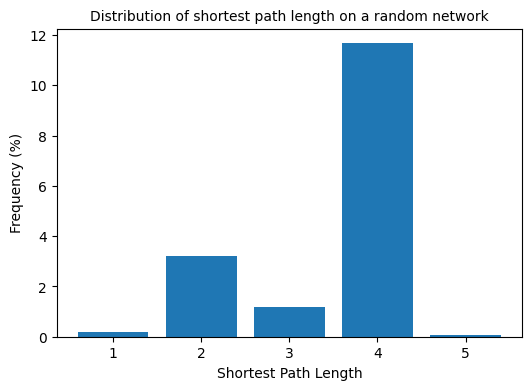

In [106]:
# Code from: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html (with a bit of tuning)

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title("Distribution of shortest path length on a random network", fontdict={"size": 10}, loc="center")
ax.set_xlabel("Shortest Path Length", fontdict={"size": 10})
ax.set_ylabel("Frequency (%)", fontdict={"size": 10})

In [107]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(network)
centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
highest_centrality = centrality[0][1]

These are the top 10 nodes with highest degree centrality:
7145 -> 0.007699141249629849
7320 -> 0.0069094857368473
8532 -> 0.006712071858651664
9061 -> 0.006712071858651664
9469 -> 0.006514657980456026
5891 -> 0.006514657980456026
9115 -> 0.006514657980456026
3103 -> 0.006514657980456026
2325 -> 0.006514657980456026
4060 -> 0.006514657980456026
